This file will be the finished version of the Radiation_workshop.ipynb

In [123]:
# Import libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp
from scipy import optimize
import pandas as pd
from os import listdir
from os.path import isfile, join
from datetime import datetime
from scipy.stats import linregress
import glob
import tikzplotlib
from matplotlib.transforms import ScaledTranslation

In [124]:
# Make a function to extract information from the names.
def extract_no(fname):
    _,_,_,no_raw,_, time_raw = fname.split("_")
    return int(no_raw)

In [125]:
# We are going to setup the files, the line, and the wavelength here

mypath = "groupA/"
preamble = "groupASMF_NQ52A00761"
#wl_chosen = 1310
#line_chosen = 5
#scan_length = 27000 # meters
#scan_time = 10
file_skip_lines = 14
#pulse_duration = 100 #ns
#print(f"Spatial resolution: {pulse_duration/10} m")

# The dose rate
dose_rate_second = 2.25 # Gy/s
dose_rate_hour = dose_rate_second*3600 # Gy/h
print(f"Dose rate is: {dose_rate_hour} Gy/h")

# Acquire all of the filenames
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] # This is because there are other disturbing file
onlyfiles.sort(key = lambda x: extract_no(x))


Dose rate is: 8100.0 Gy/h


In [126]:
# Make a function to extract information from the names.
def extract_info(fname):
    _,_,_,no_raw,_, time_raw = fname.split("_")
    combined_time = time_raw
    datetime_obj = datetime.strptime(combined_time, "%H-%M-%S-%f.txt")
    return no_raw, datetime_obj 

In [127]:
# make a function to create the filenames
def make_fname(no, datetime_obj):
    return f'{mypath}/{preamble}__{no}__{datetime_obj.strftime("%H-%M-%S-%f")[:-3]}.txt'

In [128]:
no_array = []
time_array = []

for fname in onlyfiles:
    # Extract the infos
    no_ext, time_ext = extract_info(fname)
    no_array.append(int(no_ext))
    time_array.append(time_ext)
        
      
            

Here we calculate the duration instead of the absolute time

In [129]:
start_time = 216
onlyfiles = onlyfiles[start_time:]
no_array = no_array[start_time:]
time_array = time_array[start_time:]
len_time = len(time_array)  

In [130]:
relative_time_array = np.zeros_like(time_array)
initial_time = time_array[0]
for i in range(len_time):
    relative_time_array[i] = (time_array[i] - initial_time).total_seconds() # Calculate in seconds

print(relative_time_array)
print(f"Measurement duration: {relative_time_array[-1]:.2f} seconds")
print(f"Time increment:{relative_time_array[1]-relative_time_array[0]:.2f} seconds")

[0.0 1.011 2.021 ... 6041.35 6042.361 6043.371]
Measurement duration: 6043.37 seconds
Time increment:1.01 seconds


In [131]:
ref_lines = np.loadtxt("groupA\groupASMF_NQ52A00761__0__12-42-22-575.txt",skiprows=file_skip_lines, converters=lambda s: s.replace(b',', b'.'))

dark_lines = np.loadtxt("groupA\groupASMF_NQ52A00761__161__12-45-05-253.txt",skiprows=file_skip_lines, converters=lambda s: s.replace(b',', b'.'))

lamb_array = ref_lines[:,0]

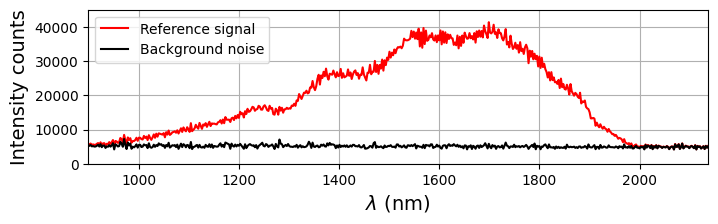

In [132]:
# Plot initial conditions:
fig_init, ax_init = plt.subplots(1,1, figsize=(8,2))
ax_init.plot(lamb_array, ref_lines[:,1], label = 'Reference signal', color = 'red')
ax_init.plot(lamb_array, dark_lines[:,1], label = 'Background noise', color = 'black')
ax_init.set_xlabel('$\lambda$ (nm)', fontsize = 14)
ax_init.set_ylabel('Intensity counts', fontsize = 14)
ax_init.set_ylim((0,45000))
ax_init.set_xlim((min(ref_lines[:,0]), max(ref_lines[:,0])))
ax_init.legend()

ax_init.grid()
#tikzplotlib.get_tikz_code()


In [133]:
lim_max = -100
lim_min = 81

lamb_array_limited = lamb_array[lim_min:lim_max]
ref_lines_limited = ref_lines[lim_min:lim_max]
dark_lines_limited = dark_lines[lim_min:lim_max]

In [134]:
# Create the matrix the column is position, the row is time.
matrix = np.array([np.loadtxt(make_fname(no_array[i],time_array[i]), skiprows=file_skip_lines, converters=lambda s: s.replace(b',', b'.'))[:,1] for i in range(len_time)])[:,lim_min:lim_max]

In [135]:
Corrected_ref = np.subtract(ref_lines_limited[:,1], dark_lines_limited[:,1])
RIA_matrix = np.zeros_like(matrix)
for i in range(RIA_matrix.shape[0]):
    RIA_matrix[i,:] = -np.log(np.divide(np.subtract(matrix[i,:], dark_lines_limited[:,1]), Corrected_ref))
    
    

C:\Users\cahya\AppData\Local\Temp\ipykernel_4908\3769241340.py:4: RuntimeWarning: divide by zero encountered in log
  RIA_matrix[i,:] = -np.log(np.divide(np.subtract(matrix[i,:], dark_lines_limited[:,1]), Corrected_ref))
C:\Users\cahya\AppData\Local\Temp\ipykernel_4908\3769241340.py:4: RuntimeWarning: invalid value encountered in log
  RIA_matrix[i,:] = -np.log(np.divide(np.subtract(matrix[i,:], dark_lines_limited[:,1]), Corrected_ref))


If the fitting is ok, it is now time to calculate the whole RIA

1098.799
1900.318


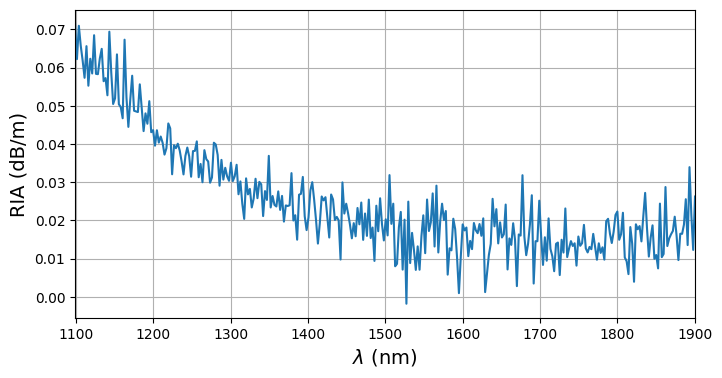

In [136]:


fig_RIA, ax_RIA = plt.subplots(1,1, figsize = (8,4))

ax_RIA.plot(lamb_array_limited, RIA_matrix[100,:])
ax_RIA.set_ylabel('RIA (dB/m)', fontsize = 14)
ax_RIA.set_xlabel('$\lambda$ (nm)', fontsize = 14)
ax_RIA.set_xlim(min(lamb_array_limited), max(lamb_array_limited))
ax_RIA.grid()
print(min(lamb_array_limited))
print(max(lamb_array_limited))





0.12448715187709798
0.10047175422127048
0.11019601709378585


Text(0.5, 0, 'Dose (kGy[SiO$_2$])')

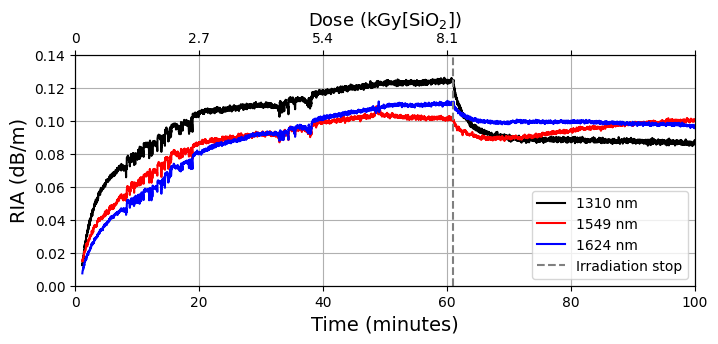

In [140]:
time_start = 70
idx_interest = np.array([117, 215, 246])-31

lamb_label = lamb_array_limited[idx_interest]
color_array = ['black','red','blue']

fig_final, ax_final = plt.subplots(1,1, figsize = (8,3))

#ax_final[0].

for i, idx in enumerate(idx_interest):
    ax_final.plot(relative_time_array[time_start:], RIA_matrix[time_start:,idx], color = color_array[i],zorder = 2, label = f"{lamb_label[i]:.0f} nm")
    print(RIA_matrix[3620,idx])
    
ax_final.set_ylabel("RIA (dB/m)", fontsize = 14)
ax_final.set_xlabel("Time (minutes)", fontsize = 14)
ax_final.set_ylim(0,0.14)
ax_final.set_xlim(0, 6000)
ax_final.grid(zorder = 1)
ax_final.axvline(relative_time_array[3620], color = 'grey', linestyle = '--', label = 'Irradiation stop')
ax_final.set_xticks([0,1200,2400,3600,4800,6000])
ax_final.set_xticklabels([0,20,40,60,80,100])
ax_final.legend()

# REMEMBER, do the second axis after the first axis
ax_final2 = ax_final.twiny()

# Set the ticks BEFORE setting the xlim!
tick_pos = ax_final.get_xticks()
ax_final2.set_xticks(tick_pos)


ax_final2.set_xlim(ax_final.get_xlim())


# Set the new labels
#new_labels = [f"{val/1000:.2f}" for i, val in enumerate(ax_final.get_xticks()*dose_rate_second)]
new_labels = [0, 2.7, 5.4, 8.1, None, None]
ax_final2.set_xticklabels(new_labels)

ax_final2.set_xlabel("Dose (kGy[SiO$_2$])", fontsize = 13)


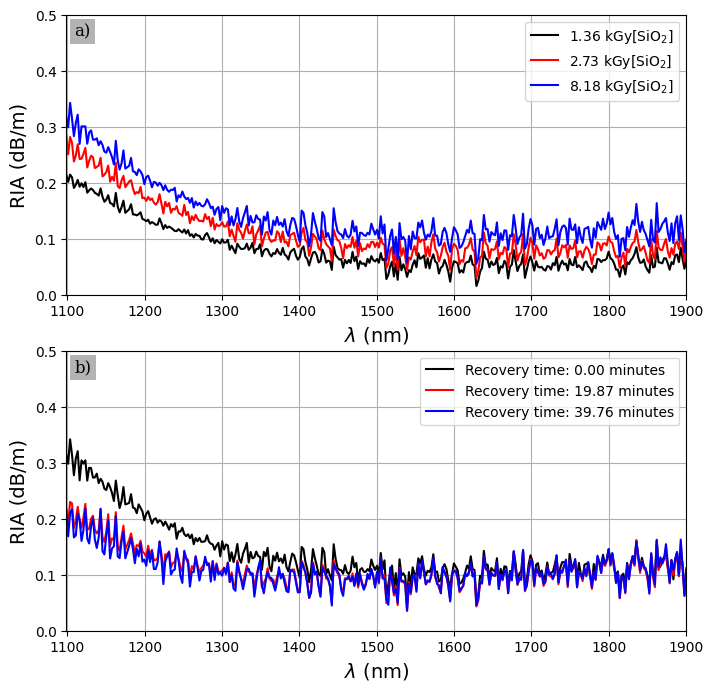

In [138]:
irr_idx = [600, 1200, 3600]
rec_idx = [3620, 4800, 5981]

fig_time, ax_time = plt.subplots(2,1, figsize = (8,8))
for i, idx in enumerate(irr_idx):
    ax_time[0].plot(lamb_array_limited, RIA_matrix[idx], label = f"{relative_time_array[idx]*dose_rate_second/1000:.2f} kGy[SiO$_2$]", color = color_array[i])
    
for i, idx in enumerate(rec_idx):
    ax_time[1].plot(lamb_array_limited, RIA_matrix[idx], label = f"Recovery time: {(relative_time_array[idx]-relative_time_array[3620])/60:.2f} minutes", color = color_array[i])
    
axs = [("a)", ax_time[0]), ("b)", ax_time[1])]    
    
for label, ax in axs:
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    ax.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='large', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

    
ax_time[0].legend()
ax_time[0].set_xlim(min(lamb_array_limited), max(lamb_array_limited))
ax_time[0].set_ylim(0,0.5)
ax_time[0].set_xlabel("$\lambda$ (nm)", fontsize = 14)
ax_time[0].set_ylabel("RIA (dB/m)", fontsize = 14)
ax_time[0].grid()

ax_time[1].legend()
ax_time[1].set_xlim(min(lamb_array_limited), max(lamb_array_limited))
ax_time[1].set_ylim(0,0.5)
ax_time[1].set_xlabel("$\lambda$ (nm)", fontsize = 14)
ax_time[1].set_ylabel("RIA (dB/m)", fontsize = 14)
ax_time[1].grid()

In [139]:
# Export the data

# aggregate all of the data first
#all_data = np.array([shifted_time_array, actual_RIA]).transpose()
#df = pd.DataFrame(all_data)
#df
#df.to_csv(f"RIA_{line_chosen}_{wl_chosen}.csv", index=False)